# Notebook structure:
* Pie-chart visualization
* Statistical fields visualization
* Preprocessing development
* Bar-chart n-grams visualization
* Word-clouds visualizations

**Dataset:** Top 100 films + low-rating films

**Dataset shape:**  60056∗2
 
**Reviews:** reviews without `nltk.stopwords`, without tags, with lemmatization

# [Kaggle_instruction](https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data)

In [17]:
%cd ../..

from typing import List, Callable

import numpy as np
import pandas as pd
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import tqdm
import dill

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer, sent_tokenize
import razdel
from nltk.corpus import stopwords
import nltk
from sklearn.utils import resample
from gensim.models import Word2Vec

from pprint import pprint

from pymystem3 import Mystem
import pymorphy2

np.set_printoptions(threshold=np.inf)

In [2]:
from datasets.getters import load_reviews_Review_Label_clean

data = load_reviews_Review_Label_clean()
data = data.drop_duplicates(subset=['review'])
data

,review,label
0,«зелёный милю» смотреть раз : 10 год назад сей...,NEUTRAL
1,период конец девяностый годов-начало двухтысяч...,POSITIVE
2,"очень сложно писать рецензия фильм , это прост...",POSITIVE
3,любимый многий миллион ценитель киноискусство ...,POSITIVE
4,наш мир существовать разный фильмов. один цепл...,POSITIVE
...,...,...
60053,"исключение легендарный 'челюсть ' , качественн...",NEUTRAL
60054,действие фильм происходить космический корабле...,NEGATIVE
60055,"стоить поверить низкий оценка смотреть фильм ,...",NEGATIVE
60056,"повестись , каждый фильм жанр фантастика , кот...",NEGATIVE


In [3]:
data.label.value_counts()

POSITIVE    47846
NEUTRAL      6743
NEGATIVE     5467
Name: label, dtype: int64

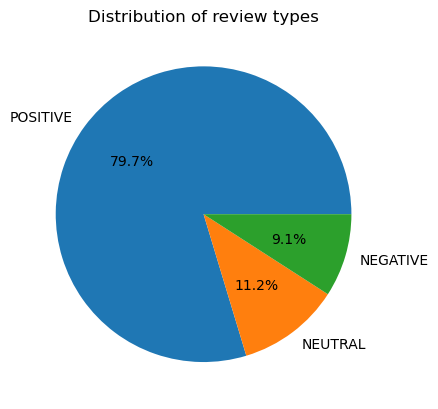

In [4]:
plt.pie(data.label.value_counts(), labels=data.label.value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of review types')
plt.show()

## Statistical fields visualization

In [5]:
texts = data.review
texts

0        «зелёный милю» смотреть раз : 10 год назад сей...
1        период конец девяностый годов-начало двухтысяч...
2        очень сложно писать рецензия фильм , это прост...
3        любимый многий миллион ценитель киноискусство ...
4        наш мир существовать разный фильмов. один цепл...
                               ...                        
60053    исключение легендарный 'челюсть ' , качественн...
60054    действие фильм происходить космический корабле...
60055    стоить поверить низкий оценка смотреть фильм ,...
60056    повестись , каждый фильм жанр фантастика , кот...
60057    последний десятилетие , фон засилье фэнтэзь , ...
Name: review, Length: 60056, dtype: object

In [6]:
data['sym_count'] = texts.str.len()
data

,review,label,sym_count
0,«зелёный милю» смотреть раз : 10 год назад сей...,NEUTRAL,2026
1,период конец девяностый годов-начало двухтысяч...,POSITIVE,2241
2,"очень сложно писать рецензия фильм , это прост...",POSITIVE,1824
3,любимый многий миллион ценитель киноискусство ...,POSITIVE,1437
4,наш мир существовать разный фильмов. один цепл...,POSITIVE,2164
...,...,...,...
60053,"исключение легендарный 'челюсть ' , качественн...",NEUTRAL,1981
60054,действие фильм происходить космический корабле...,NEGATIVE,1288
60055,"стоить поверить низкий оценка смотреть фильм ,...",NEGATIVE,1147
60056,"повестись , каждый фильм жанр фантастика , кот...",NEGATIVE,6147


In [7]:
data.describe()

,sym_count
count,60056.000000
mean,2006.568270
std,1210.462837
min,39.000000
25%,1128.000000
50%,1705.000000
75%,2591.000000
max,17686.000000


In [8]:
data['token_count'] = texts.apply(lambda txt: len(txt.split()))
data

,review,label,sym_count,token_count
0,«зелёный милю» смотреть раз : 10 год назад сей...,NEUTRAL,2026,286
1,период конец девяностый годов-начало двухтысяч...,POSITIVE,2241,329
2,"очень сложно писать рецензия фильм , это прост...",POSITIVE,1824,241
3,любимый многий миллион ценитель киноискусство ...,POSITIVE,1437,190
4,наш мир существовать разный фильмов. один цепл...,POSITIVE,2164,304
...,...,...,...,...
60053,"исключение легендарный 'челюсть ' , качественн...",NEUTRAL,1981,274
60054,действие фильм происходить космический корабле...,NEGATIVE,1288,170
60055,"стоить поверить низкий оценка смотреть фильм ,...",NEGATIVE,1147,148
60056,"повестись , каждый фильм жанр фантастика , кот...",NEGATIVE,6147,803


In [9]:
data['sent_count'] = texts.apply(lambda txt: len(sent_tokenize(txt)))
data

,review,label,sym_count,token_count,sent_count
0,«зелёный милю» смотреть раз : 10 год назад сей...,NEUTRAL,2026,286,23
1,период конец девяностый годов-начало двухтысяч...,POSITIVE,2241,329,15
2,"очень сложно писать рецензия фильм , это прост...",POSITIVE,1824,241,26
3,любимый многий миллион ценитель киноискусство ...,POSITIVE,1437,190,7
4,наш мир существовать разный фильмов. один цепл...,POSITIVE,2164,304,32
...,...,...,...,...,...
60053,"исключение легендарный 'челюсть ' , качественн...",NEUTRAL,1981,274,18
60054,действие фильм происходить космический корабле...,NEGATIVE,1288,170,14
60055,"стоить поверить низкий оценка смотреть фильм ,...",NEGATIVE,1147,148,18
60056,"повестись , каждый фильм жанр фантастика , кот...",NEGATIVE,6147,803,45


In [10]:
data['mean_token_length'] = texts.map(lambda txt: np.mean([len(word) for word in txt.split()]))
data

,review,label,sym_count,token_count,sent_count,mean_token_length
0,«зелёный милю» смотреть раз : 10 год назад сей...,NEUTRAL,2026,286,23,6.087413
1,период конец девяностый годов-начало двухтысяч...,POSITIVE,2241,329,15,5.814590
2,"очень сложно писать рецензия фильм , это прост...",POSITIVE,1824,241,26,6.572614
3,любимый многий миллион ценитель киноискусство ...,POSITIVE,1437,190,7,6.568421
4,наш мир существовать разный фильмов. один цепл...,POSITIVE,2164,304,32,6.121711
...,...,...,...,...,...,...
60053,"исключение легендарный 'челюсть ' , качественн...",NEUTRAL,1981,274,18,6.233577
60054,действие фильм происходить космический корабле...,NEGATIVE,1288,170,14,6.582353
60055,"стоить поверить низкий оценка смотреть фильм ,...",NEGATIVE,1147,148,18,6.756757
60056,"повестись , каждый фильм жанр фантастика , кот...",NEGATIVE,6147,803,45,6.656289


In [11]:
data['mean_sent_length'] = texts.map(lambda txt: np.mean([len(sent.split()) for sent in sent_tokenize(txt)]))
data

,review,label,sym_count,token_count,sent_count,mean_token_length,mean_sent_length
0,«зелёный милю» смотреть раз : 10 год назад сей...,NEUTRAL,2026,286,23,6.087413,12.434783
1,период конец девяностый годов-начало двухтысяч...,POSITIVE,2241,329,15,5.814590,21.933333
2,"очень сложно писать рецензия фильм , это прост...",POSITIVE,1824,241,26,6.572614,9.269231
3,любимый многий миллион ценитель киноискусство ...,POSITIVE,1437,190,7,6.568421,27.285714
4,наш мир существовать разный фильмов. один цепл...,POSITIVE,2164,304,32,6.121711,9.531250
...,...,...,...,...,...,...,...
60053,"исключение легендарный 'челюсть ' , качественн...",NEUTRAL,1981,274,18,6.233577,15.222222
60054,действие фильм происходить космический корабле...,NEGATIVE,1288,170,14,6.582353,12.142857
60055,"стоить поверить низкий оценка смотреть фильм ,...",NEGATIVE,1147,148,18,6.756757,8.222222
60056,"повестись , каждый фильм жанр фантастика , кот...",NEGATIVE,6147,803,45,6.656289,17.844444


([<matplotlib.patches.Wedge at 0x24cfbe51be0>,
 [Text(-0.6465637441936393, 0.8899187180267096, 'POSITIVE'),
  Text(0.20611935297230619, -1.0805159935559852, 'NEUTRAL'),
  Text(0.9953097129848338, -0.4683573157729554, 'NEGATIVE')],
 [Text(-0.3526711331965305, 0.4854102098327506, '70.0%'),
  Text(0.11242873798489426, -0.5893723601214464, '16.0%'),
  Text(0.5428962070826365, -0.25546762678524837, '14.0%')])

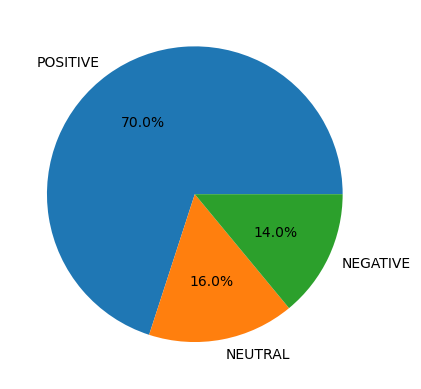

In [12]:
plt.pie(data.sort_values(by='sent_count', ascending=False)[:100].label.value_counts(), labels=data.label.value_counts().index, autopct='%1.1f%%')

---

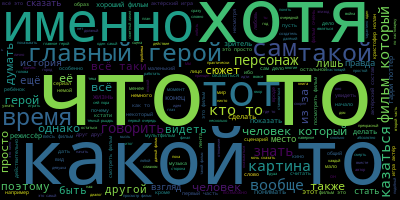

In [13]:
wc = WordCloud().generate(' '.join(data.review))
wc.to_image()

## Visualization

In [14]:
def get_n_most_frequent_ngrams(data, ngram_range: tuple = (1, 1), top_n: int = 10):
    print(f'{ngram_range=}')
    print('Building vocabulary...')
    cnt_vec = CountVectorizer(ngram_range=ngram_range)
    cnt_vec.fit(data)
    print('Vectorizing documents...')
    docs_embs = cnt_vec.transform(data)
    print(f'{docs_embs.shape=}')
    
    print('Preparing values...')    
    token_freqs = np.array(np.sum(docs_embs, axis=0))[0]
    max_idxs = np.argpartition(token_freqs, -top_n)[-top_n:]
    max_freqs = token_freqs[max_idxs]
    most_frequent_tokens = cnt_vec.get_feature_names_out()[max_idxs]

    concated = pd.DataFrame(np.concatenate((max_freqs.reshape(-1, 1), most_frequent_tokens.reshape(-1, 1)), axis=1), 
                            columns=['freqs', 'tokens'])
    
    concated.sort_values(by=['freqs'], inplace=True, ascending=False, ignore_index=True)
    
    print(end='\n')
        
    return concated
    

In [15]:
data

,review,label,sym_count,token_count,sent_count,mean_token_length,mean_sent_length
0,«зелёный милю» смотреть раз : 10 год назад сей...,NEUTRAL,2026,286,23,6.087413,12.434783
1,период конец девяностый годов-начало двухтысяч...,POSITIVE,2241,329,15,5.814590,21.933333
2,"очень сложно писать рецензия фильм , это прост...",POSITIVE,1824,241,26,6.572614,9.269231
3,любимый многий миллион ценитель киноискусство ...,POSITIVE,1437,190,7,6.568421,27.285714
4,наш мир существовать разный фильмов. один цепл...,POSITIVE,2164,304,32,6.121711,9.531250
...,...,...,...,...,...,...,...
60053,"исключение легендарный 'челюсть ' , качественн...",NEUTRAL,1981,274,18,6.233577,15.222222
60054,действие фильм происходить космический корабле...,NEGATIVE,1288,170,14,6.582353,12.142857
60055,"стоить поверить низкий оценка смотреть фильм ,...",NEGATIVE,1147,148,18,6.756757,8.222222
60056,"повестись , каждый фильм жанр фантастика , кот...",NEGATIVE,6147,803,45,6.656289,17.844444


In [18]:
get_n_most_frequent_ngrams(data.review, top_n=30)

ngram_range=(1, 1)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(60056, 223045)
Preparing values...



,freqs,tokens
0,278874,фильм
1,198860,это
2,170707,который
3,107894,свой
4,78824,человек
5,77951,очень
6,68201,то
7,65818,10
8,64453,такой
9,60397,просто


In [19]:
get_n_most_frequent_ngrams(data.review, ngram_range=(4, 4), top_n=30)

ngram_range=(4, 4)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(60056, 13720377)
Preparing values...



,freqs,tokens
0,310,тёмный рыцарь возрождение легенды
1,306,загадочный история бенджамин баттона
2,291,гарри поттер дар смерть
3,273,гарри поттер принц полукровка
4,241,гарри поттер философский камень
5,228,поттер дар смерть часть
6,214,фильм основать реальный событие
7,199,фильм смотреться один дыхание
8,191,приятный просмотр 10 10
9,176,гарри поттер дар смерти


In [20]:
def visualize_ngram_occurrences(corpus, ngram_range: tuple = (1, 1), top_n = 10):
    assert len(ngram_range) == 2, "Wrong length of ngram_range parameter. Expected 'ngram_range' == 2."
    
    fig, ax = plt.subplots(ngram_range[1] - ngram_range[0] + 1, 1, figsize=(3 + ngram_range[1] * 2.5, ngram_range[1] * (1.1 + (top_n-1) / 8)))

    if not isinstance(ax, np.ndarray):
         ax = np.array([ax])    
    
    for i, ngram in enumerate(range(ngram_range[0], ngram_range[1] + 1)):
        df = get_n_most_frequent_ngrams(corpus, ngram_range=(ngram, ngram), top_n=top_n)
        sns.barplot(x=df['freqs'], y=df['tokens'], ax=ax[i])
        ax[i].set_title(f'Top 10 Most Frequently Occuring {(ngram, ngram)} ngrams', weight='bold')
        ax[i].grid(color='gainsboro')
    
    plt.tight_layout()

ngram_range=(1, 1)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(60056, 223045)
Preparing values...

ngram_range=(2, 2)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(60056, 5911135)
Preparing values...

ngram_range=(3, 3)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(60056, 12175696)
Preparing values...

ngram_range=(4, 4)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(60056, 13720377)
Preparing values...

Wall time: 4min 42s


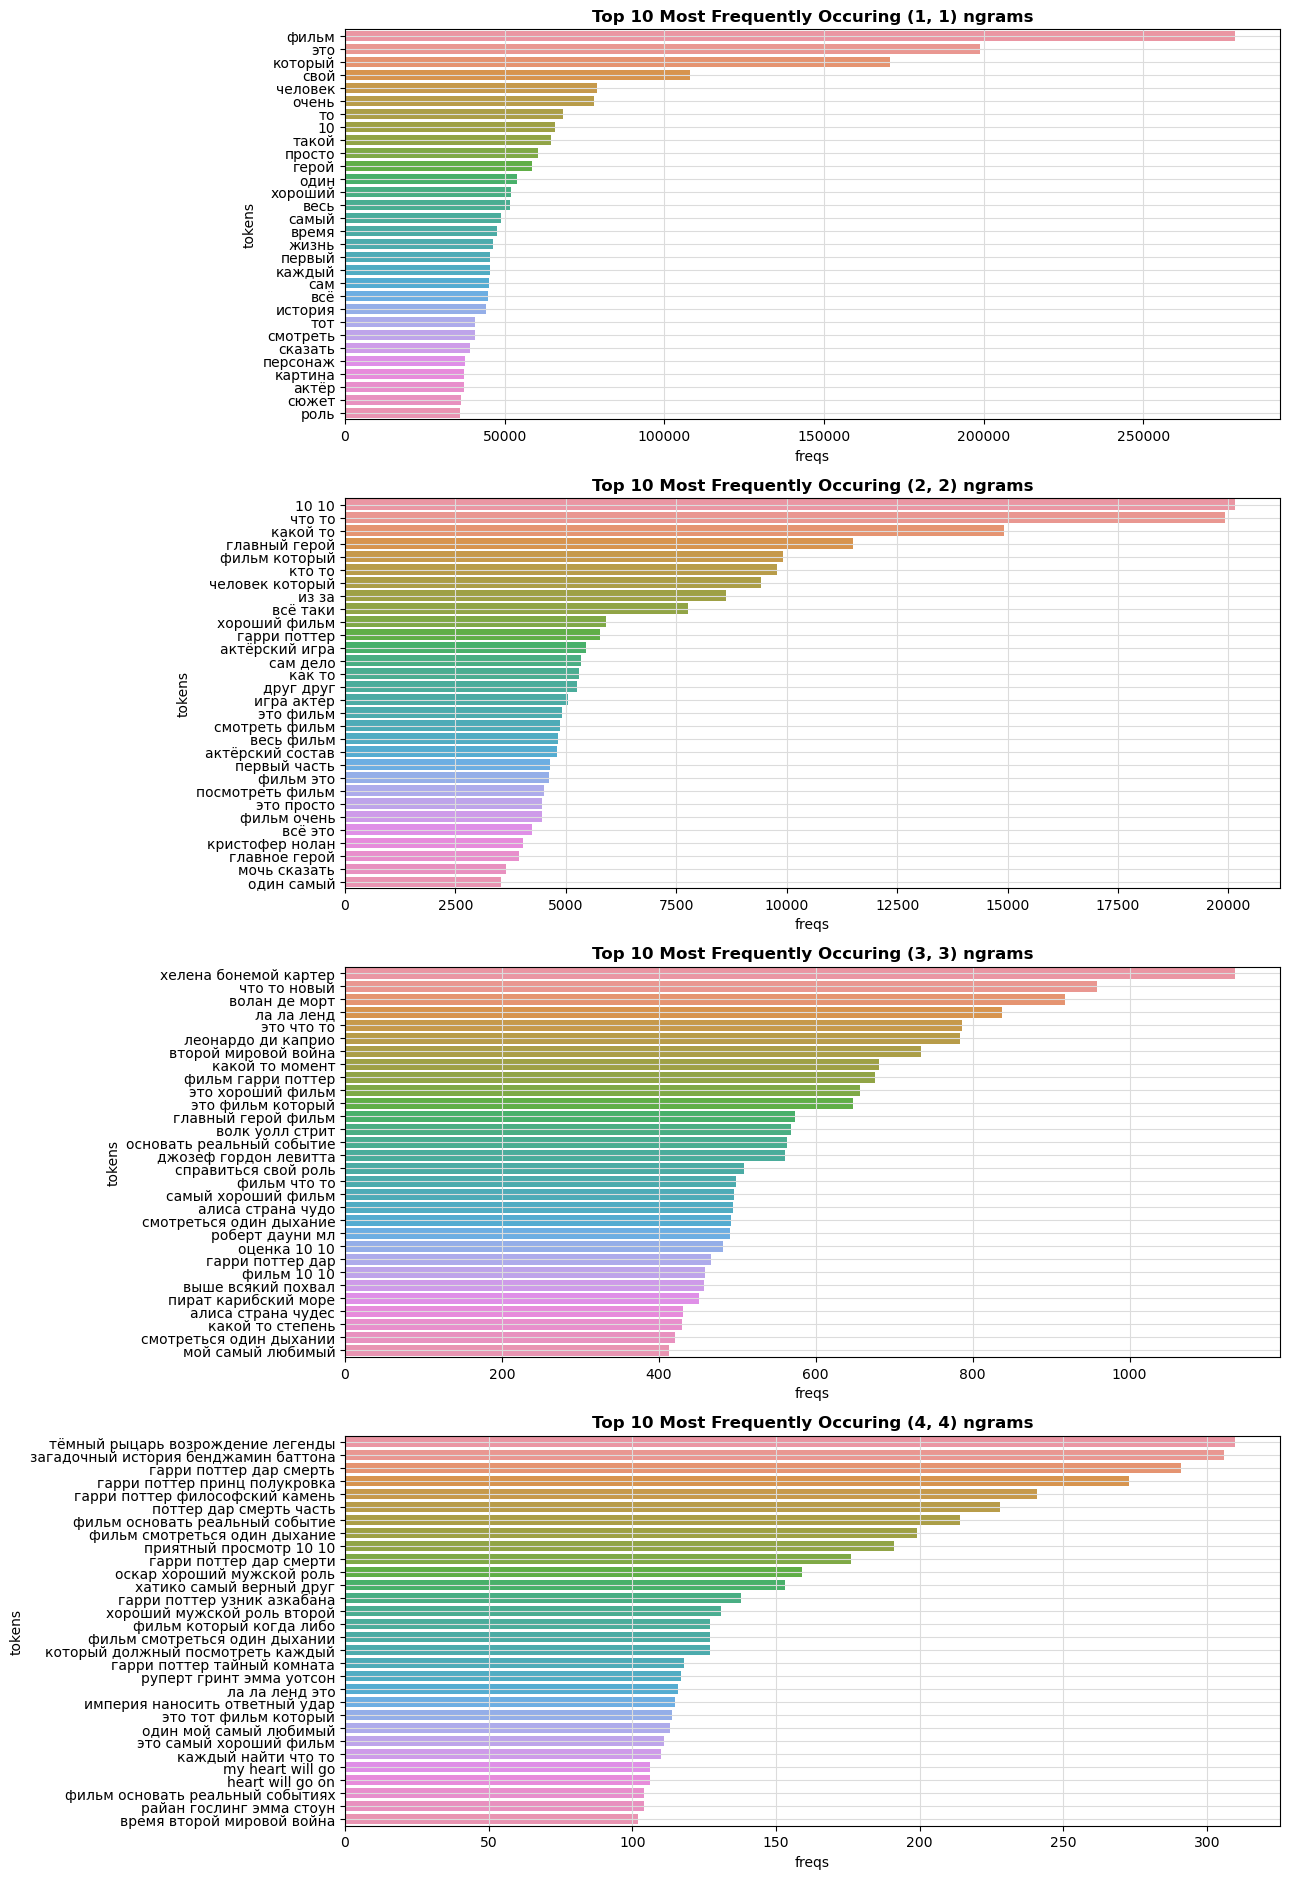

In [21]:
%%time

visualize_ngram_occurrences(data.review, top_n=30, ngram_range=(1, 4))

In [22]:
positive_data = data[data.label == 'POSITIVE']
neutral_data = data[data.label == 'NEUTRAL']
negative_data = data[data.label == 'NEGATIVE']

print(f'Initial {data.shape=}')

(positive_data.shape, neutral_data.shape, negative_data.shape)

Initial data.shape=(60056, 7)


((47846, 7), (6743, 7), (5467, 7))

ngram_range=(1, 1)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(47846, 192145)
Preparing values...

ngram_range=(2, 2)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(47846, 4810561)
Preparing values...

ngram_range=(3, 3)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(47846, 9698937)
Preparing values...

ngram_range=(4, 4)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(47846, 10897109)
Preparing values...

Wall time: 3min 42s


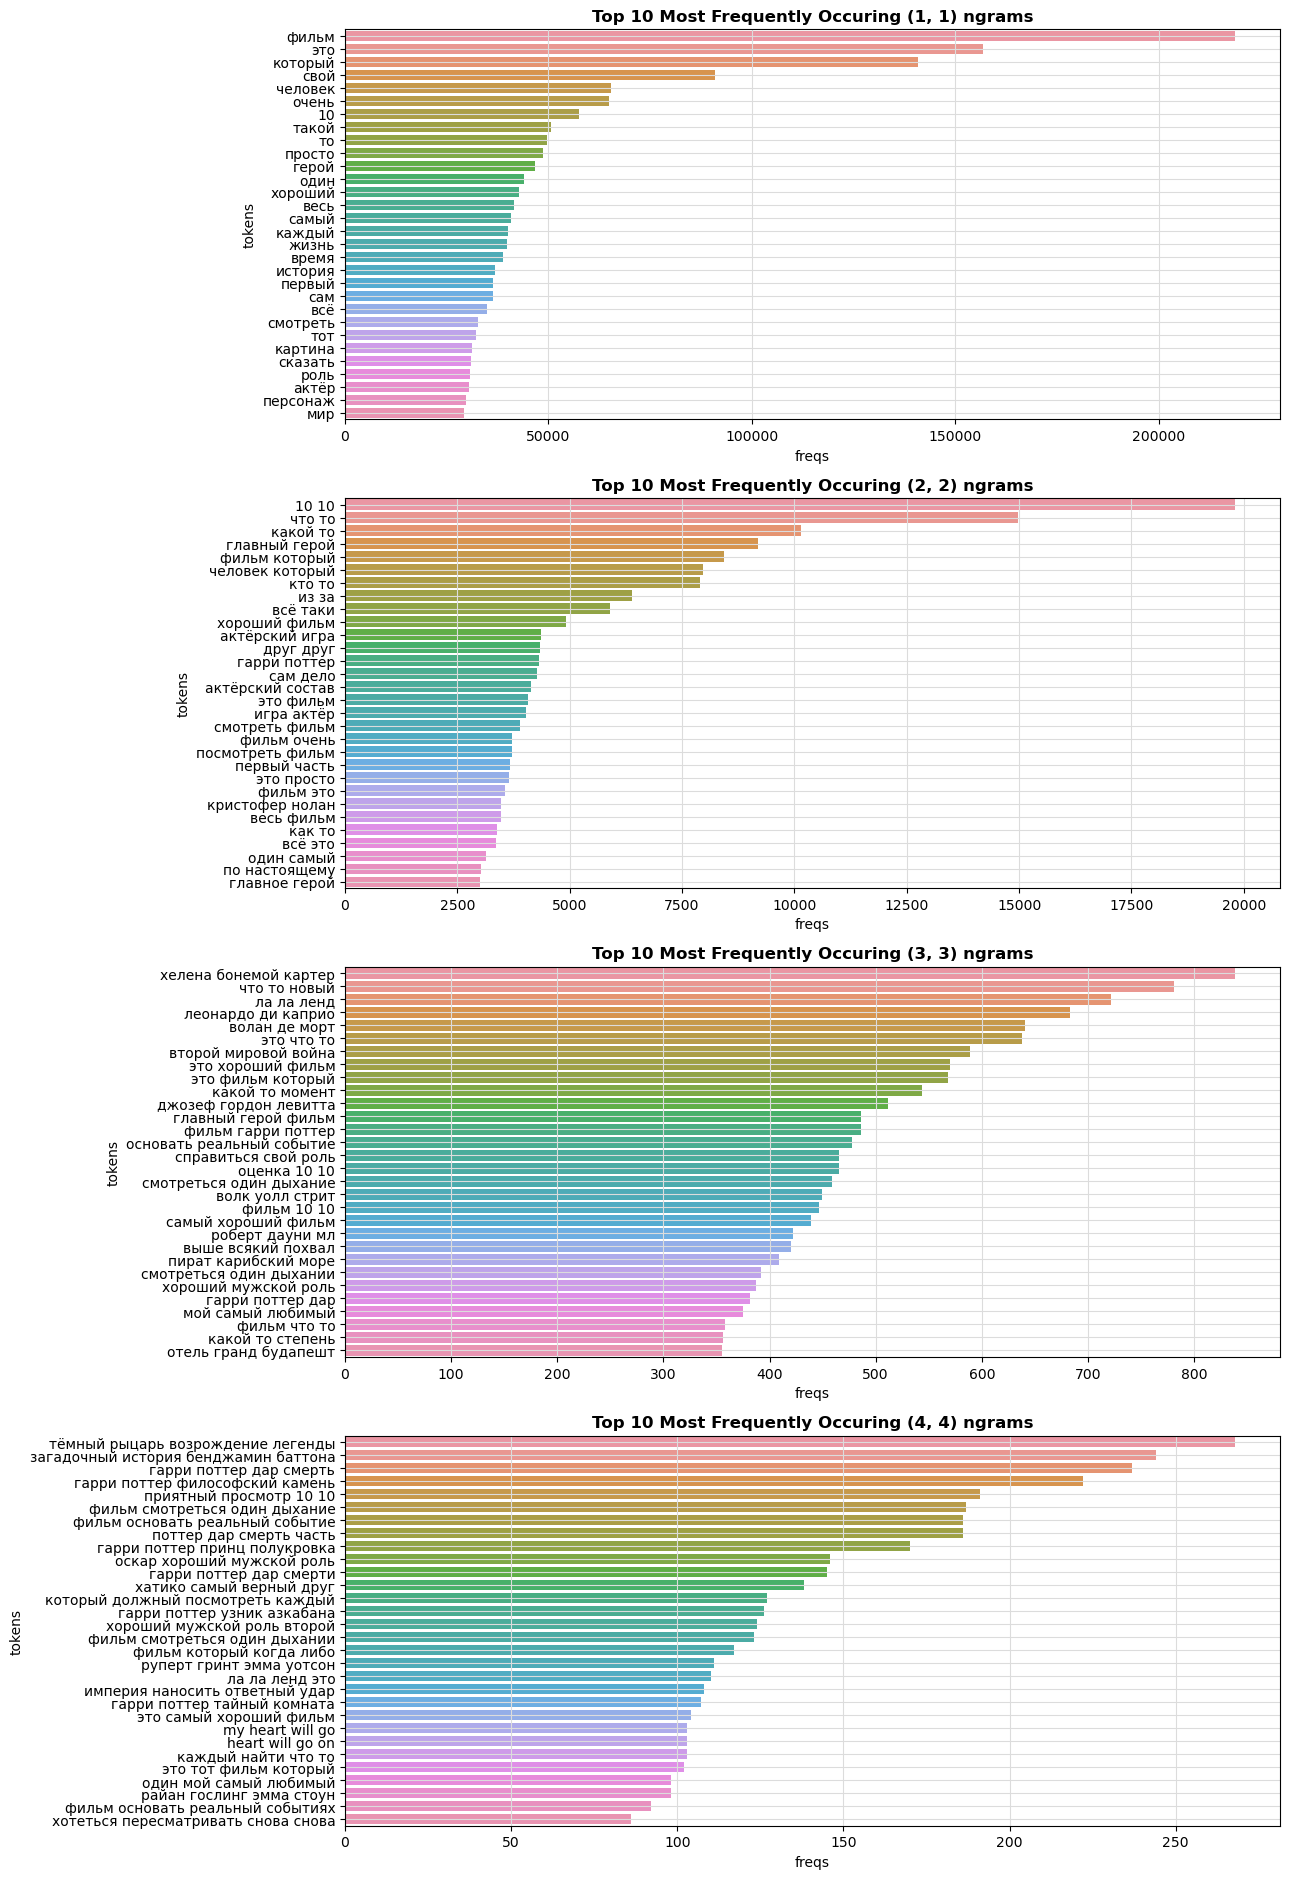

In [23]:
%%time

visualize_ngram_occurrences(positive_data.review, top_n=30, ngram_range=(1, 4))

ngram_range=(1, 1)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(6743, 81758)
Preparing values...

ngram_range=(2, 2)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(6743, 1022966)
Preparing values...

ngram_range=(3, 3)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(6743, 1481524)
Preparing values...

ngram_range=(4, 4)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(6743, 1535088)
Preparing values...

Wall time: 29.2 s


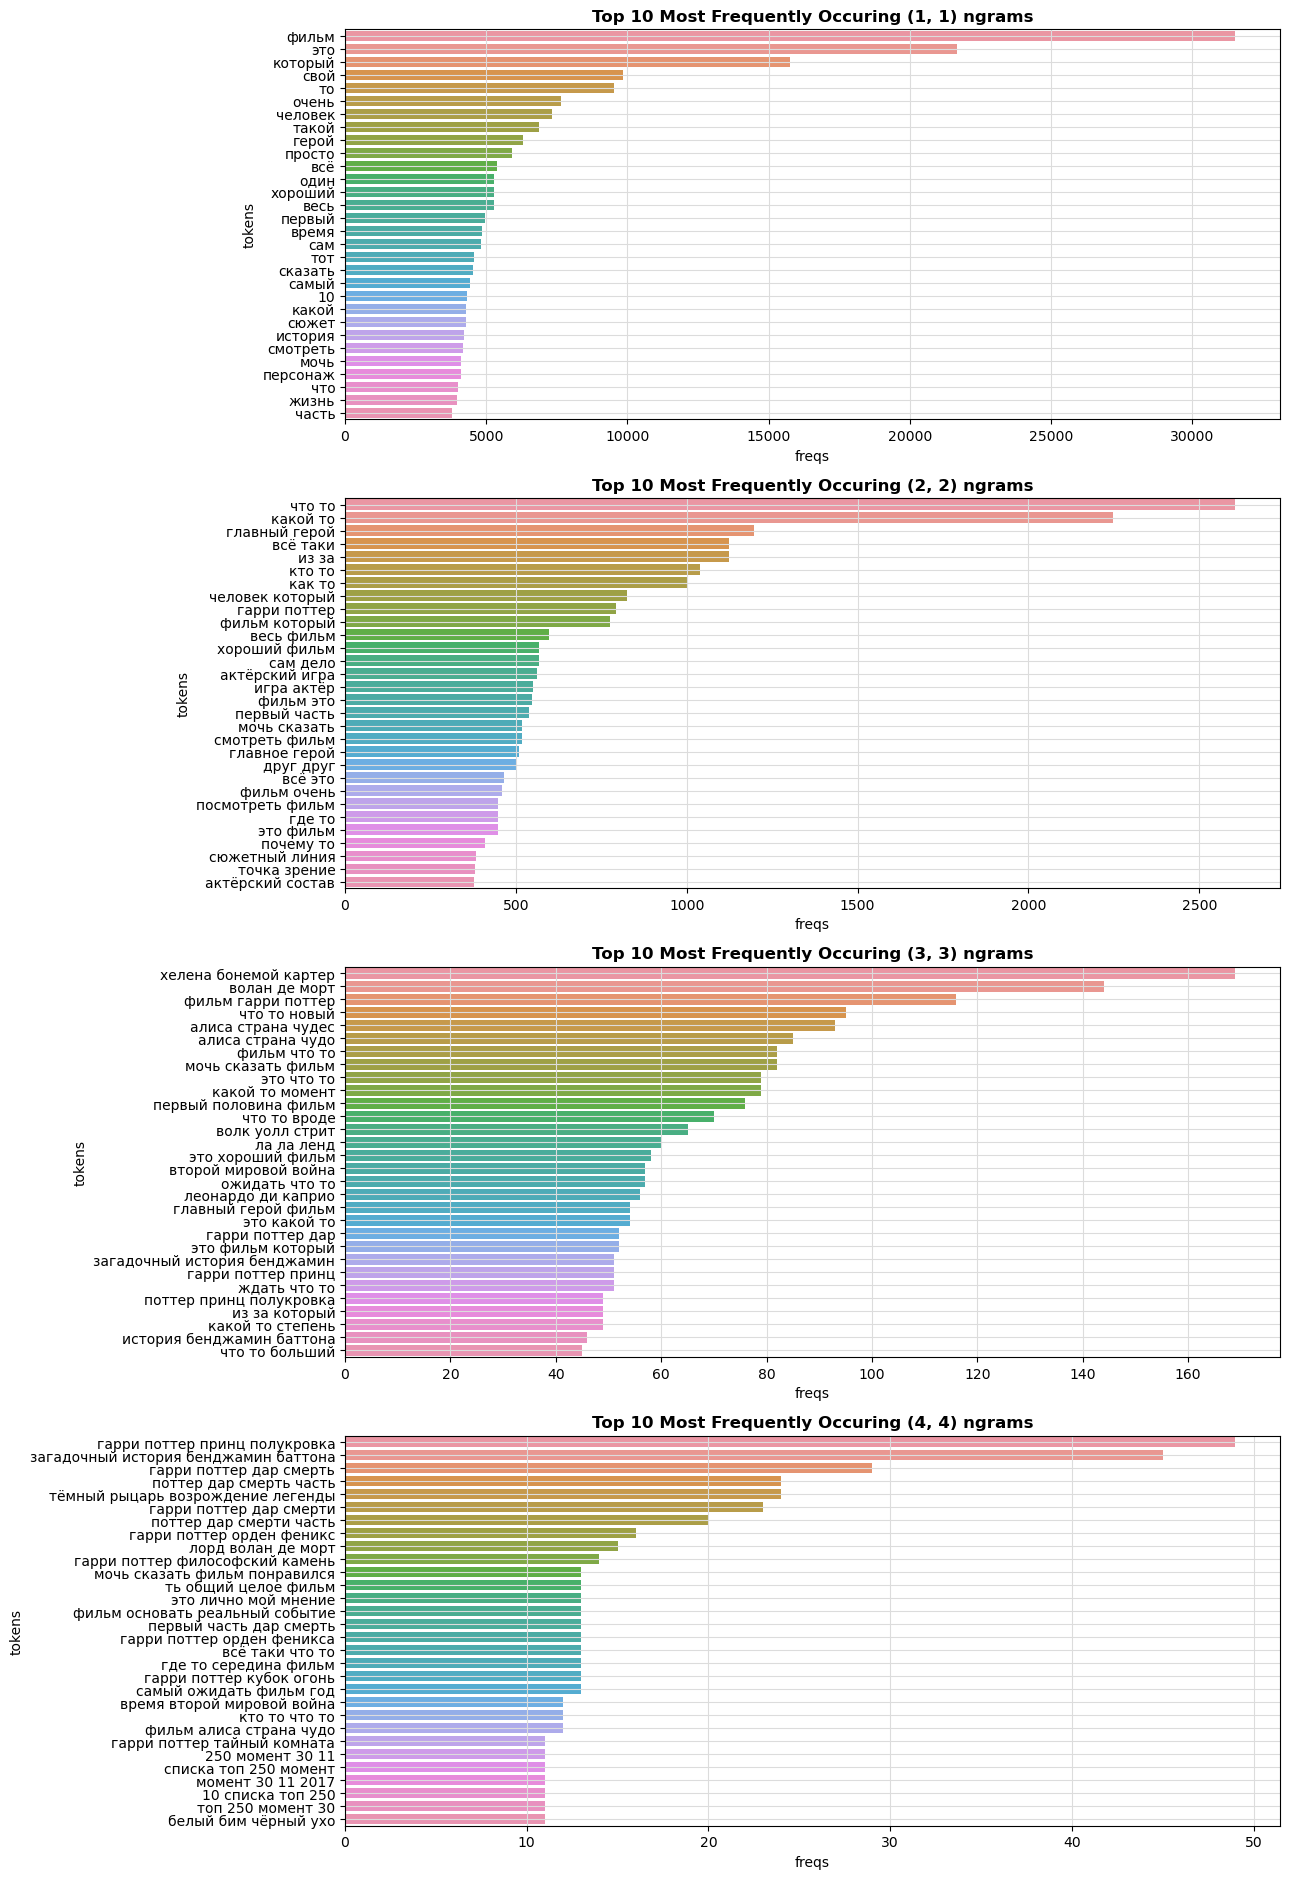

In [24]:
%%time

visualize_ngram_occurrences(neutral_data.review, top_n=30, ngram_range=(1, 4))

ngram_range=(1, 1)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(5467, 76690)
Preparing values...

ngram_range=(2, 2)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(5467, 916061)
Preparing values...

ngram_range=(3, 3)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(5467, 1301786)
Preparing values...

ngram_range=(4, 4)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(5467, 1344964)
Preparing values...

Wall time: 25.8 s


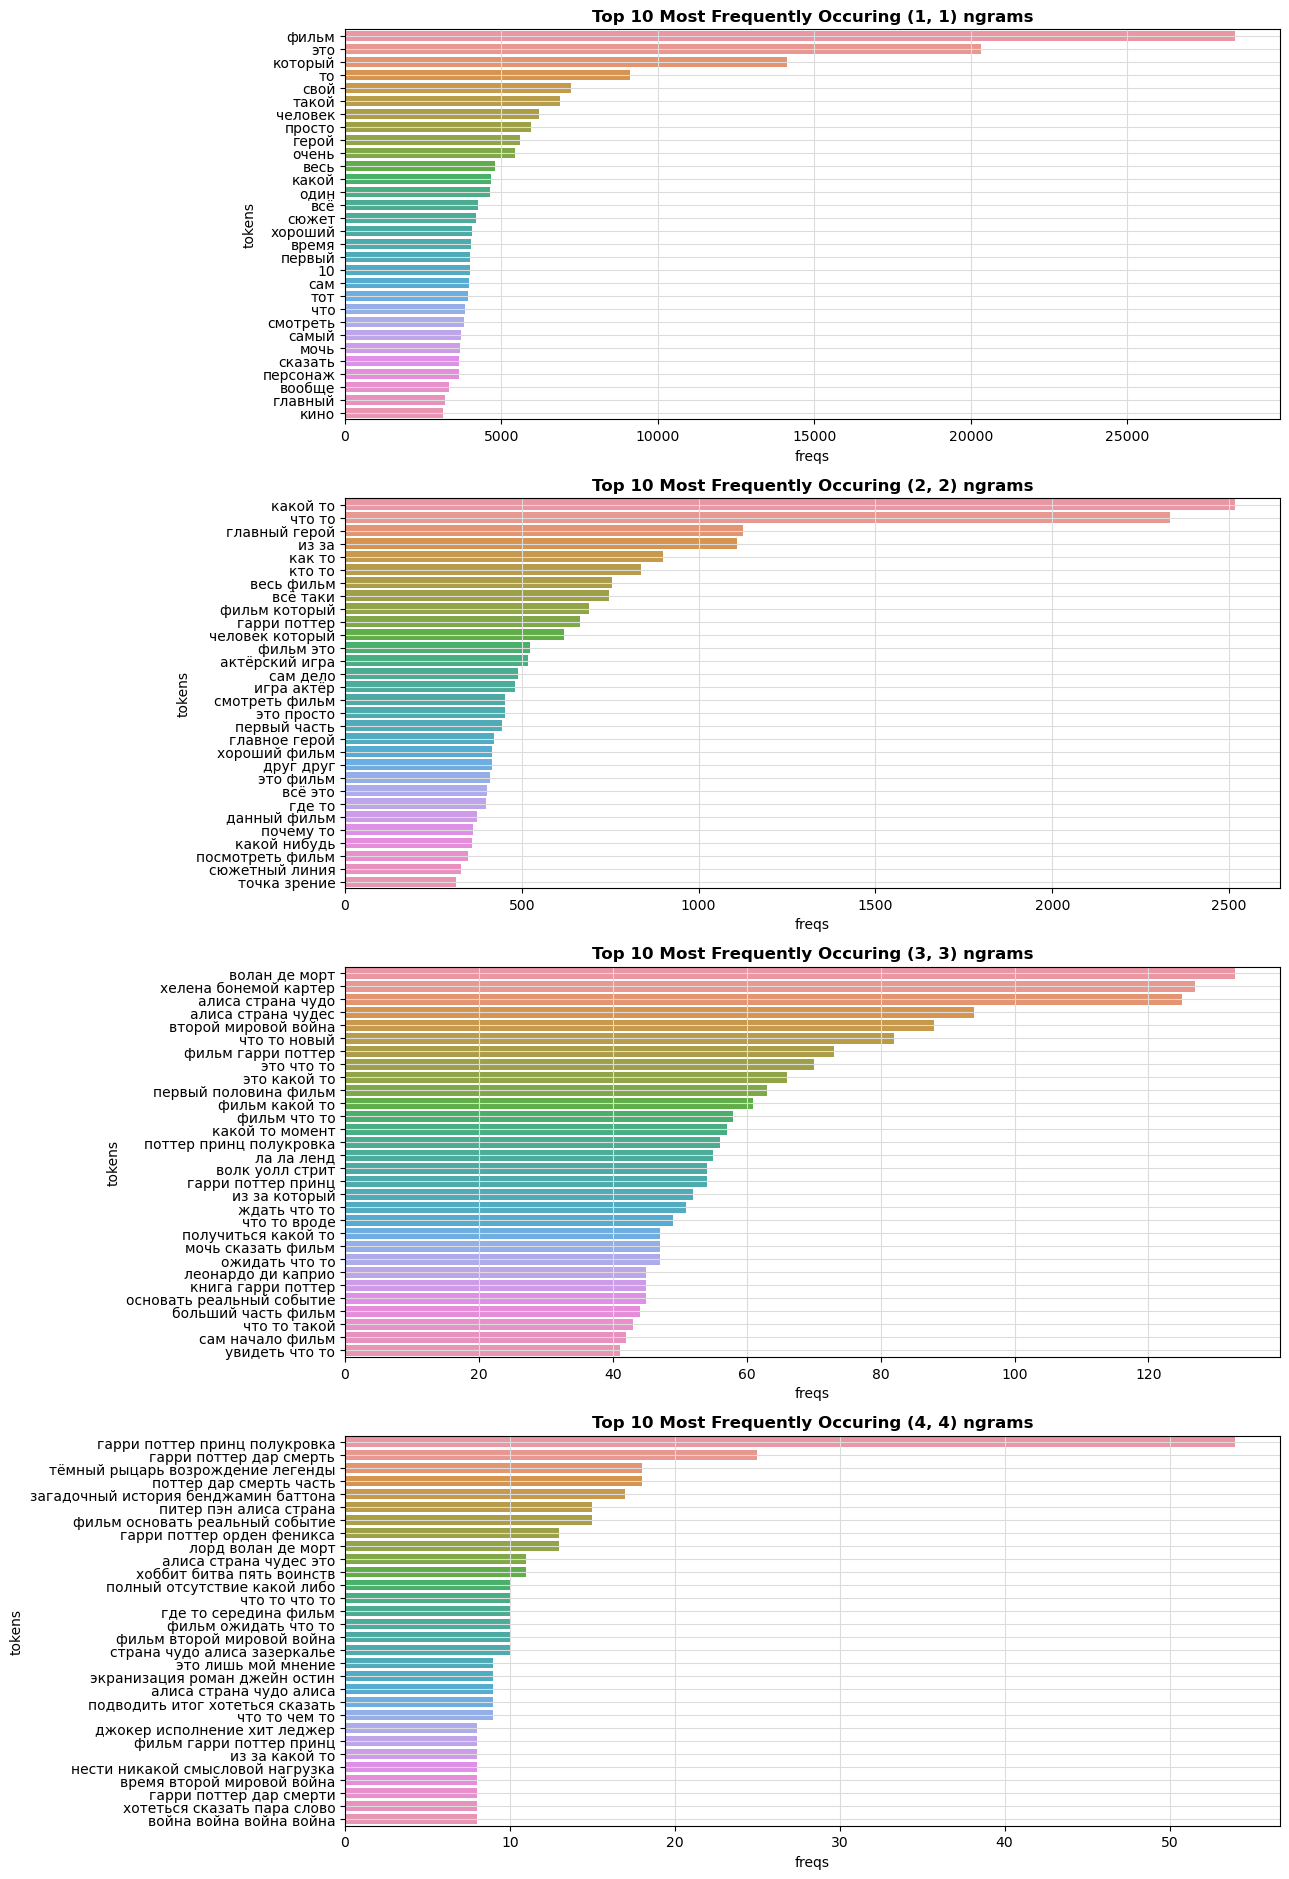

In [25]:
%%time

visualize_ngram_occurrences(negative_data.review, top_n=30, ngram_range=(1, 4))

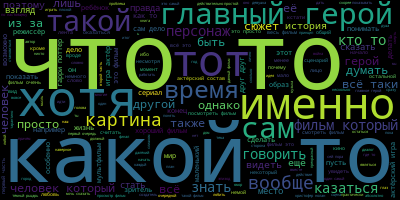

In [26]:
wc = WordCloud().generate(' '.join(data.review))
wc.to_image()

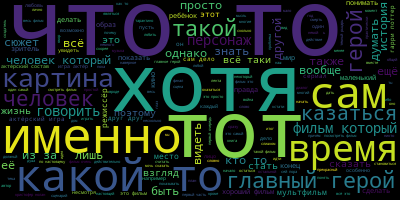

In [27]:
wc = WordCloud().generate(' '.join(positive_data.review))
wc.to_image()

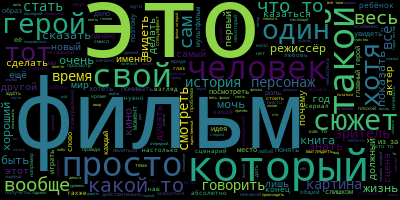

In [28]:
wc = WordCloud().generate(' '.join(negative_data.review))
wc.to_image()